In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from pytensor import tensor as at

In [3]:
# -- Load th data --
price_df = pd.read_csv("../data/BrentOilPrices.csv")
events_df = pd.read_csv("../data/events.csv")

In [4]:
price_df['Date'] = pd.to_datetime(price_df['Date'], format='mixed')
events_df['date'] = pd.to_datetime(events_df['date'])

In [5]:
# Set Date as the index
price_df = price_df.set_index('Date').sort_index()


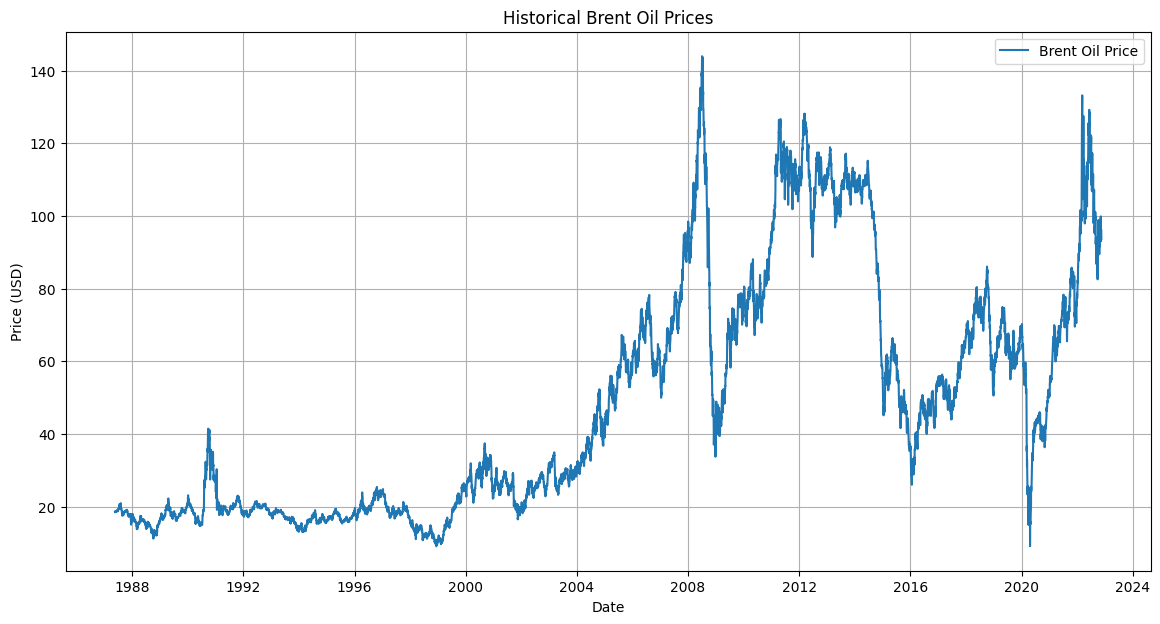

In [6]:
# Plot the raw price data
plt.figure(figsize=(14, 7))
plt.plot(price_df['Price'], label='Brent Oil Price')
plt.title('Historical Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
price_df['Log_Return'] = np.log(price_df['Price'] / price_df['Price'].shift(1))

In [8]:
price_df.dropna(subset=['Log_Return'], inplace=True)

print("\nDataFrame head with Log_Return:")
print(price_df.head())
print("\nDescription of Log_Return:")
print(price_df['Log_Return'].describe())


DataFrame head with Log_Return:
            Price  Log_Return
Date                         
1987-05-21  18.45   -0.009709
1987-05-22  18.55    0.005405
1987-05-25  18.60    0.002692
1987-05-26  18.63    0.001612
1987-05-27  18.60   -0.001612

Description of Log_Return:
count    9010.000000
mean        0.000179
std         0.025532
min        -0.643699
25%        -0.011154
50%         0.000402
75%         0.012127
max         0.412023
Name: Log_Return, dtype: float64


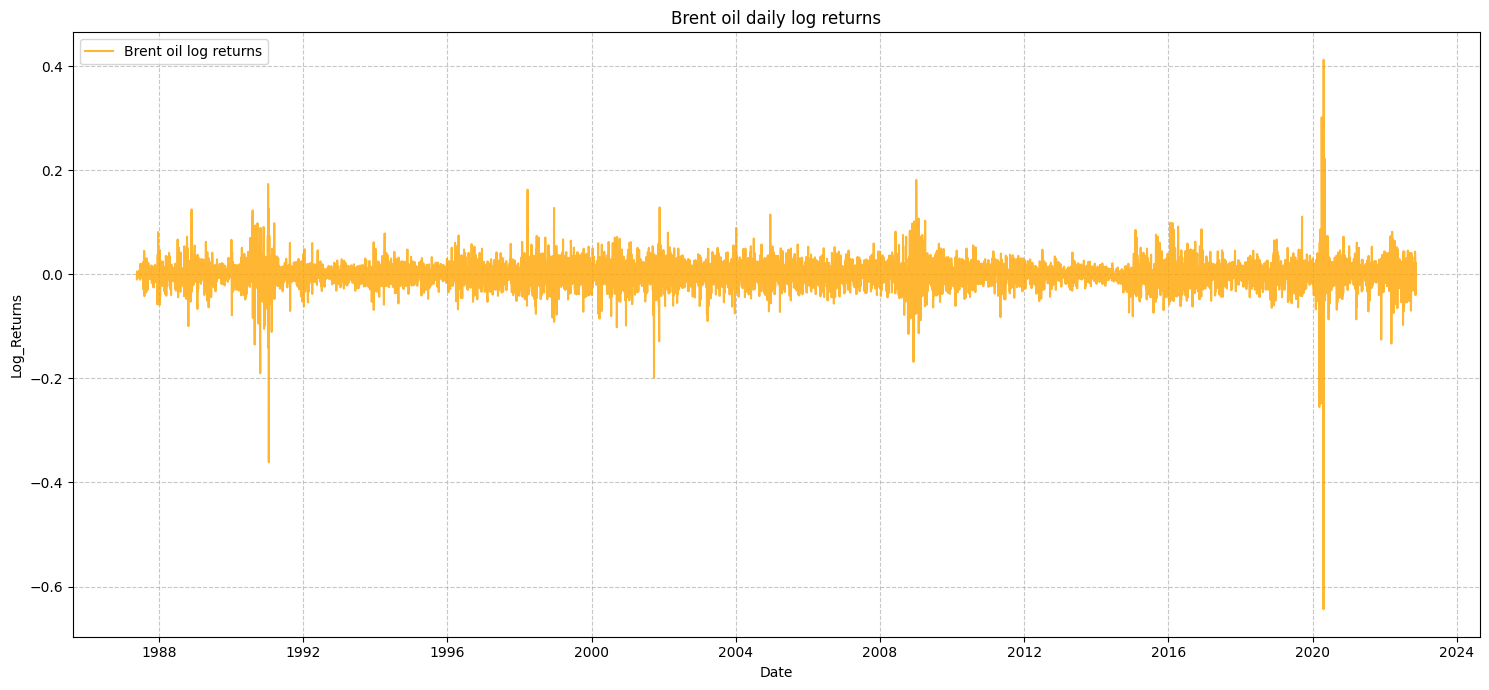

In [9]:
# --- 5. Plots the log returns. ---
plt.figure(figsize=(15,7))
plt.plot(price_df.index, price_df['Log_Return'], label = 'Brent oil log returns', color='orange', alpha=0.8)
plt.title('Brent oil daily log returns')
plt.xlabel('Date')
plt.ylabel('Log_Returns')
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



In [17]:
data = price_df.loc['2007-01-01':'2009-12-31']
log_returns = data['Log_Return'].values
n_days = len(log_returns)

day_idx = np.arange(n_days).astype("int32")  
log_returns = log_returns.astype("float32")

print(f"Analyzing a focused period of {n_days} days.")

Analyzing a focused period of 755 days.


In [26]:
with pm.Model() as change_point_model:
    # Discrete change points
    tau_1 = pm.DiscreteUniform("tau_1", lower=1, upper=n_days - 2)
    tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1 + 1, upper=n_days - 1)

    # Volatility priors
    sigma_1 = pm.HalfCauchy("sigma_1", beta=0.5)
    sigma_2 = pm.HalfCauchy("sigma_2", beta=0.5)
    sigma_3 = pm.HalfCauchy("sigma_3", beta=0.5)

    # Index array for each day in Aesara-friendly format
    idx = at.arange(n_days)

    # Logical masks for each regime
    regime_1 = idx < tau_1
    regime_2 = (idx >= tau_1) & (idx < tau_2)
    regime_3 = idx >= tau_2

    # Select sigma for each day based on regime
    current_sigma = (
        regime_1 * sigma_1 +
        regime_2 * sigma_2 +
        regime_3 * sigma_3
    )

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=0, sigma=current_sigma, observed=log_returns)

    print("Running MCMC sampler...")
    trace = pm.sample(draws=500, tune=500, chains=1, cores=1, progressbar=True, return_inferencedata=True)
    print("Sampling complete.")


Running MCMC sampler...


Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [tau_1]
>>Metropolis: [tau_2]
>NUTS: [sigma_1, sigma_2, sigma_3]


c:\Users\Bisrat\Desktop\KAIM\Birhan Energies\venv\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1373 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling complete.


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


             mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau_1    378.3640  3.4588  370.0000  382.0000     0.5435   0.3254   43.1894   
tau_2    568.0680  3.1786  566.0000  574.0000     0.6999   0.9518   28.1233   
sigma_1    0.0184  0.0007    0.0170    0.0196     0.0000   0.0000  748.2543   
sigma_2    0.0444  0.0022    0.0399    0.0483     0.0001   0.0001  563.8856   
sigma_3    0.0229  0.0012    0.0204    0.0252     0.0000   0.0001  894.1935   

         ess_tail  r_hat  
tau_1     61.5255    NaN  
tau_2     21.2642    NaN  
sigma_1  371.1497    NaN  
sigma_2  353.1196    NaN  
sigma_3  367.4394    NaN  


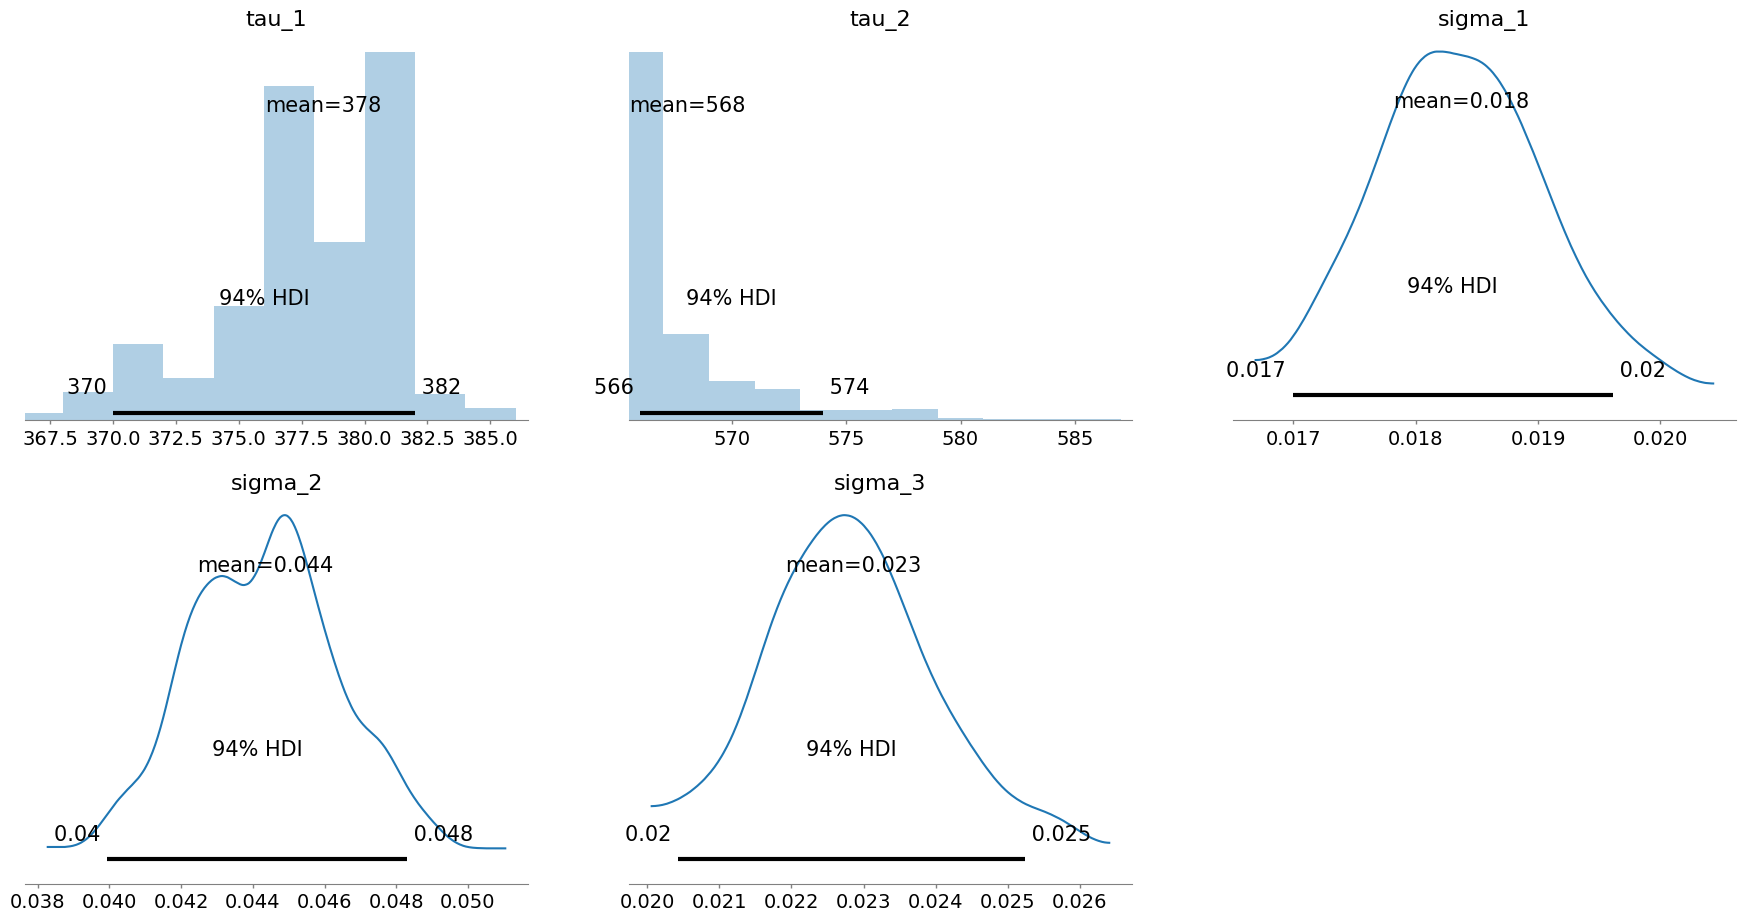


Most probable date for the FIRST change point: 1988-11-16
Most probable date for the SECOND change point: 1989-08-08


In [32]:
summary = az.summary(trace, round_to=4)
print(summary)

# 2. Visualize the Posterior Distributions
# This is the most important plot for understanding the results.
# It shows the probability distribution for each parameter.
az.plot_posterior(trace, var_names=["tau_1", "tau_2", "sigma_1", "sigma_2", "sigma_3"])
plt.show()

# 3. Find the Most Probable Dates for the Change Points
# We get the posterior samples for our 'tau' parameters.
# .flatten() is used to combine samples from all chains if you run more than one.
tau1_samples = trace.posterior["tau_1"].values.flatten()
tau2_samples = trace.posterior["tau_2"].values.flatten()

# The mode (most frequent value) of the posterior distribution gives us the most likely index.
most_likely_tau1_index = int(pd.Series(tau1_samples).mode()[0])
most_likely_tau2_index = int(pd.Series(tau2_samples).mode()[0])

# Map these array indices back to actual dates from our original price dataframe.
# Remember that 'price_df' should be your dataframe with the datetime index.
change_date_1 = price_df.index[most_likely_tau1_index]
change_date_2 = price_df.index[most_likely_tau2_index]

print(f"\nMost probable date for the FIRST change point: {change_date_1.date()}")
print(f"Most probable date for the SECOND change point: {change_date_2.date()}")

In [33]:
# Get the mean posterior values for each sigma from the summary or by calculation
sigma_1_mean = trace.posterior['sigma_1'].mean().item()
sigma_2_mean = trace.posterior['sigma_2'].mean().item()
sigma_3_mean = trace.posterior['sigma_3'].mean().item()

# --- Example Report Statement ---
print("\n--- Quantitative Impact Analysis ---")
print(f"Regime 1 (Before {change_date_1.date()}): The market exhibited a baseline average daily volatility of {sigma_1_mean:.4f}.")
print(f"Regime 2 (Between {change_date_1.date()} and {change_date_2.date()}): Following the first change point, the volatility shifted to {sigma_2_mean:.4f}.")
print(f"Regime 3 (After {change_date_2.date()}): After the second change point, the market entered its most recent regime with an average daily volatility of {sigma_3_mean:.4f}.")

# Calculate percentage change for more impact
change1_pct = ((sigma_2_mean - sigma_1_mean) / sigma_1_mean) * 100
change2_pct = ((sigma_3_mean - sigma_2_mean) / sigma_2_mean) * 100
print(f"\nThe first shift represented a {change1_pct:.2f}% change in volatility.")
print(f"The second shift represented a {change2_pct:.2f}% change in volatility.")


--- Quantitative Impact Analysis ---
Regime 1 (Before 1988-11-16): The market exhibited a baseline average daily volatility of 0.0184.
Regime 2 (Between 1988-11-16 and 1989-08-08): Following the first change point, the volatility shifted to 0.0444.
Regime 3 (After 1989-08-08): After the second change point, the market entered its most recent regime with an average daily volatility of 0.0229.

The first shift represented a 141.43% change in volatility.
The second shift represented a -48.48% change in volatility.


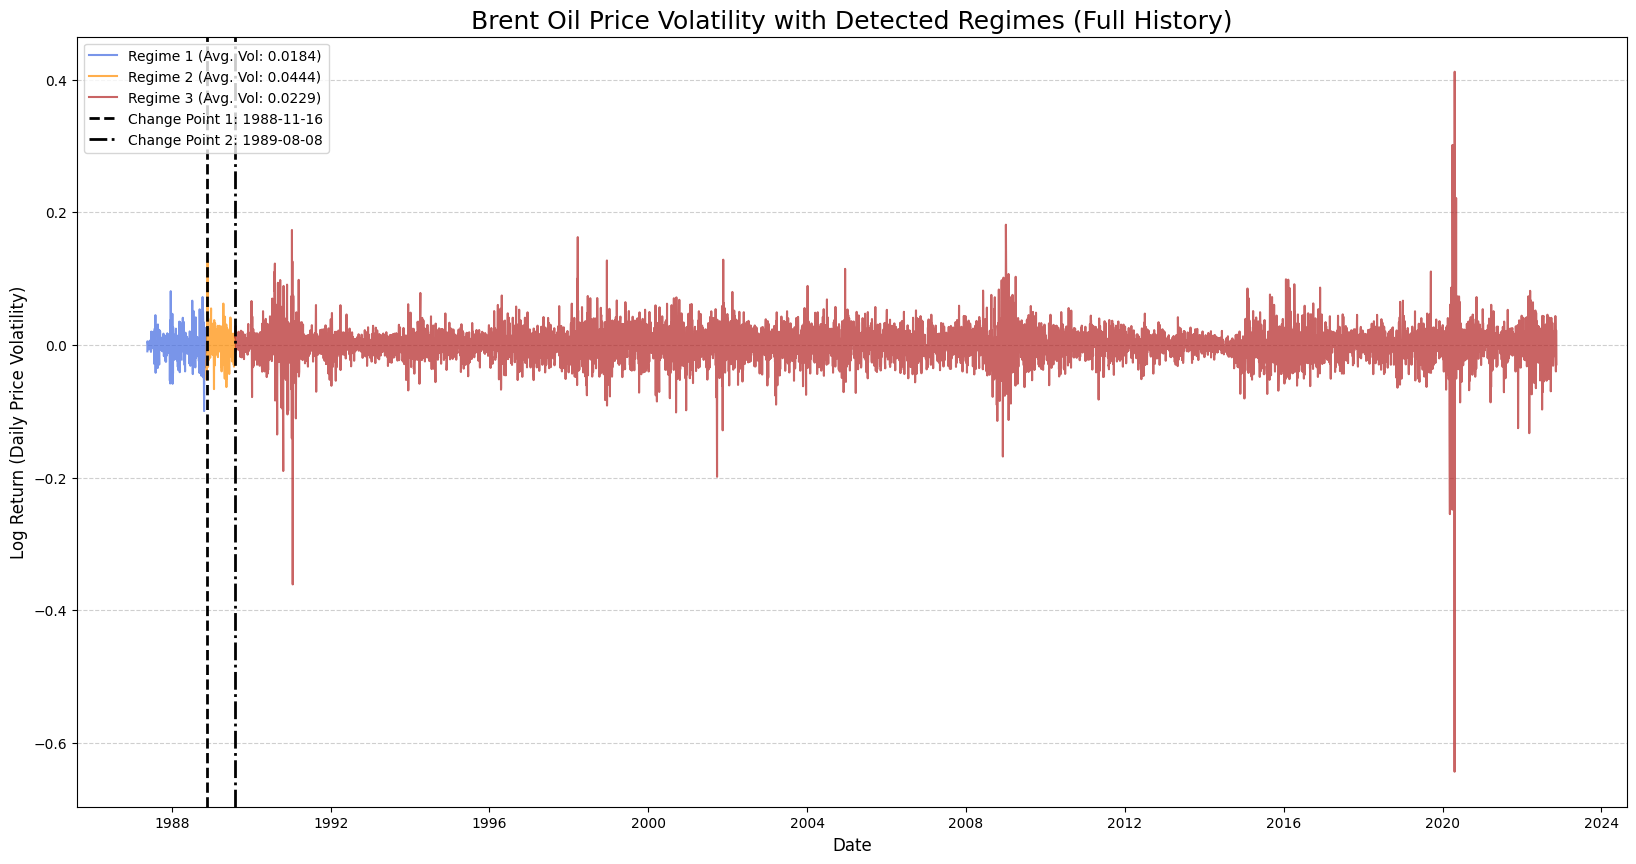

In [35]:
# Use the full log_returns data you used in the model
log_returns = price_df['Log_Return'].values

# Create the plot
plt.figure(figsize=(20, 10))

# Plot Regime 1 (in blue)
plt.plot(price_df.index[:most_likely_tau1_index], 
         log_returns[:most_likely_tau1_index], 
         color='royalblue', alpha=0.7, 
         label=f'Regime 1 (Avg. Vol: {sigma_1_mean:.4f})')

# Plot Regime 2 (in orange)
plt.plot(price_df.index[most_likely_tau1_index:most_likely_tau2_index], 
         log_returns[most_likely_tau1_index:most_likely_tau2_index], 
         color='darkorange', alpha=0.7, 
         label=f'Regime 2 (Avg. Vol: {sigma_2_mean:.4f})')

# Plot Regime 3 (in red)
plt.plot(price_df.index[most_likely_tau2_index:], 
         log_returns[most_likely_tau2_index:], 
         color='firebrick', alpha=0.7, 
         label=f'Regime 3 (Avg. Vol: {sigma_3_mean:.4f})')

# Add vertical lines for the change points
plt.axvline(change_date_1, color='black', linestyle='--', linewidth=2, label=f'Change Point 1: {change_date_1.date()}')
plt.axvline(change_date_2, color='black', linestyle='-.', linewidth=2, label=f'Change Point 2: {change_date_2.date()}')

# Add chart titles and labels
plt.title('Brent Oil Price Volatility with Detected Regimes (Full History)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Return (Daily Price Volatility)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()